In [1]:
import pennylane as qml
from pennylane import numpy as np

# Define the Grover's algorithm circuit with expectation value measurements
def grover_circuit_expectation(x):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

    # Oracle for the problem we want to solve (e.g., searching for a specific state)
    oracle_expectation(x)

    # Grover diffusion operator
    grover_diffusion()

# Oracle implementation with expectation value measurement (modify based on the problem)
def oracle_expectation(x):
    qml.CNOT(wires=[0, 1])
    qml.PauliX(wires=1)
    qml.CNOT(wires=[0, 1])
    qml.Rot(x, x, x, wires=0)

# Grover diffusion operator
def grover_diffusion():
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.CNOT(wires=[0, 1])
    qml.Hadamard(wires=1)
    qml.PauliX(wires=0)
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)

# Define the quantum device
dev = qml.device("default.qubit", wires=2)

# Define the quantum circuit using the grover_circuit_expectation function
@qml.qnode(dev)
def full_grover_circuit_expectation(x):
    grover_circuit_expectation(x)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

# Define the parameter
x = np.array(0.5, requires_grad=True)

# Execute the full Grover's algorithm circuit with expectation value measurement
expval_full = full_grover_circuit_expectation(x)

# Apply quantum circuit cutting to the Grover's algorithm with expectation value measurement
@qml.cut_circuit(auto_cutter=True)
@qml.qnode(dev)
def cut_grover_circuit_expectation(x):
    grover_circuit_expectation(x)
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

# Execute the cut Grover's algorithm circuit with expectation value measurement
expval_cut = cut_grover_circuit_expectation(x)

# Compare the results
print("Full Grover's Algorithm Circuit:")
print(expval_full)

print("\nCut Grover's Algorithm Circuit:")
print(expval_cut)

/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/transforms/core/transform_dispatcher.py:130: PennyLaneDeprecationWarning: Decorating a QNode with @transform_fn(**transform_kwargs) has been deprecated and will be removed in a future version. Please decorate with @functools.partial(transform_fn, **transform_kwargs) instead, or call the transform directly using qnode = transform_fn(qnode, **transform_kwargs). Visit the deprecations page for more details: https://docs.pennylane.ai/en/stable/development/deprecations.html
  warnings.warn(
/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (40).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")


Full Grover's Algorithm Circuit:
0.0

Cut Grover's Algorithm Circuit:
2.0496389657846047e-17


Using alice & bob EMU:40Q:LOGICAL_TARGET backend...


/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/transforms/core/transform_dispatcher.py:130: PennyLaneDeprecationWarning: Decorating a QNode with @transform_fn(**transform_kwargs) has been deprecated and will be removed in a future version. Please decorate with @functools.partial(transform_fn, **transform_kwargs) instead, or call the transform directly using qnode = transform_fn(qnode, **transform_kwargs). Visit the deprecations page for more details: https://docs.pennylane.ai/en/stable/development/deprecations.html
  warnings.warn(
/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/qcut/cutstrategy.py:367: UserWarning: The numer of partition attempts seems high (70).
  warnings.warn(f"The numer of partition attempts seems high ({len(ks)}).")
/usr/local/python/3.11.8/lib/python3.11/site-packages/pennylane/transforms/core/transform_dispatcher.py:130: PennyLaneDeprecationWarning: Decorating a QNode with @transform_fn(**transform_kwargs) has been deprecated an

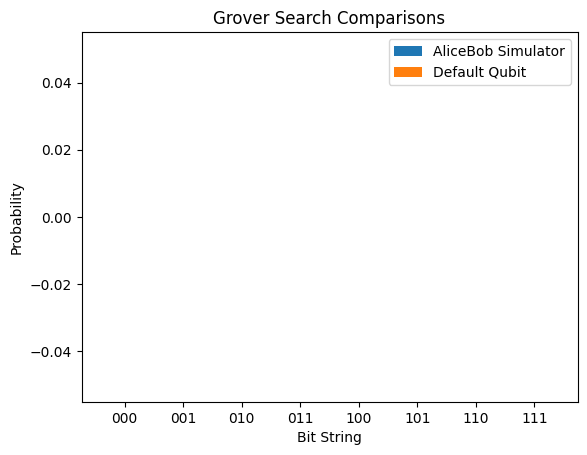

In [101]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Defining the oracle and the GroverSearch function
n_wires = 3
wires = list(range(n_wires))

def oracle():
    qml.Hadamard(wires[-1])
    qml.Toffoli(wires=wires)
    qml.Hadamard(wires[-1])

def GroverSearch(device, num_iterations=1):
    dev = device
    
    n_qubit = 3
    
    @qml.cut_circuit_mc(auto_cutter=True)
    @qml.qnode(dev)
    def circuit():
        for wire in wires:
            qml.Hadamard(wire)

        for _ in range(num_iterations):
            oracle()
            qml.templates.GroverOperator(wires=wires)

        return qml.sample(wires=[0,1,2,3])
    

    res = circuit()
    #print(res)
    bitstrings = ["{0:0{1}b}".format(i, n_qubit) for i in range(2**n_qubit)]
    probs = []
    str_res = []
    for r in res:
        str_res.append("".join([str(int(i)) for i in r]))
    for b in bitstrings:
        probs.append(str_res.count(b) / len(res))

    #print(probs)

    return probs

# Devices
alice_bob_dev = qml.device("alicebob.qubit", alice_backend="EMU:40Q:LOGICAL_TARGET", wires=3, average_nb_photons=8, kappa_1=10, kappa_2=1e8, shots=100)
default_dev = qml.device("default.qubit", wires=3, shots=100)

# Getting results from both devices
alicebob_results = GroverSearch(alice_bob_dev, num_iterations=2)
default_results = GroverSearch(default_dev, num_iterations=2)

# Generating bit strings for x-axis labels
bit_strings = [f"{x:0{n_wires}b}" for x in range(2**n_wires)]

# Plotting
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(default_results))

bar1 = ax.bar(index, alicebob_results, bar_width, label='AliceBob Simulator')
bar2 = ax.bar(index + bar_width, default_results, bar_width, label='Default Qubit')

ax.set_xlabel('Bit String')
ax.set_ylabel('Probability')
ax.set_title('Grover Search Comparisons')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(bit_strings)
ax.legend()

plt.show()

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 [0. 0. 1.]
 [1. 0. 1.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 0. 0.]
 [1. 0. 1.]
 [1. 0. 1.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1.

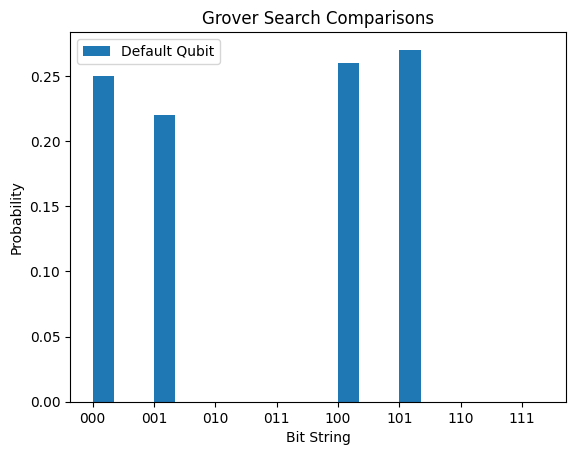

In [97]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from functools import partial
# Defining the oracle and the GroverSearch function
n_wires = 3
wires = list(range(n_wires))

def oracle():
    qml.Hadamard(wires[-1])
    qml.Toffoli(wires=wires)
    qml.Hadamard(wires[-1])

def GroverSearch(device, num_iterations=1):
    dev = device
    
    n_qubit = 3

    @partial(qml.cut_circuit_mc, auto_cutter=True)
    @qml.qnode(dev)
    def circuit():
        x = 0.531
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)


        qml.CZ(wires=[0, 1])
        qml.Hadamard(wires=0)

        qml.CZ(wires=[1, 2])

        return qml.sample(wires=[0, 1, 2])
    

    res = circuit()
    print(res)
    bitstrings = ["{0:0{1}b}".format(i, n_qubit) for i in range(2**n_qubit)]
    probs = []
    str_res = []
    for r in res:
        str_res.append("".join([str(int(i)) for i in r]))
    for b in bitstrings:
        probs.append(str_res.count(b) / len(res))

    print(probs)

    return probs

# Devices
#alice_bob_dev = qml.device("alicebob.qubit", alice_backend="EMU:40Q:LOGICAL_TARGET", wires=3, average_nb_photons=8, kappa_1=10, kappa_2=1e8, shots=100)
default_dev = qml.device("default.qubit", wires=3, shots=100)

# Getting results from both devices
#alicebob_results = GroverSearch(alice_bob_dev, num_iterations=2)
default_results = GroverSearch(default_dev, num_iterations=2)

# Generating bit strings for x-axis labels
bit_strings = [f"{x:0{n_wires}b}" for x in range(2**n_wires)]

# Plotting
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(default_results))

#bar1 = ax.bar(index, alicebob_results, bar_width, label='AliceBob Simulator')
bar2 = ax.bar(index + bar_width, default_results, bar_width, label='Default Qubit')

ax.set_xlabel('Bit String')
ax.set_ylabel('Probability')
ax.set_title('Grover Search Comparisons')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(bit_strings)
ax.legend()

plt.show()

[[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0.

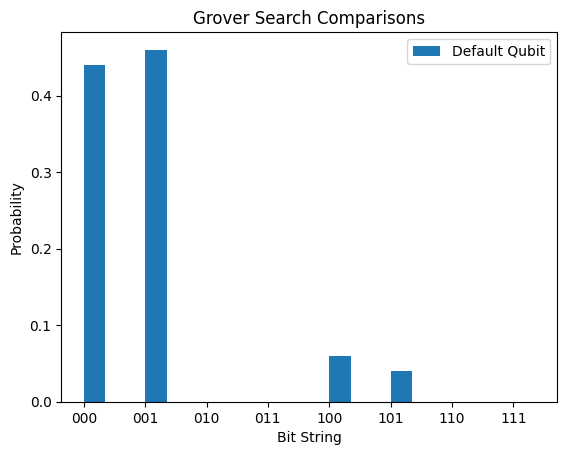

In [87]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Defining the oracle and the GroverSearch function
n_wires = 3
wires = list(range(n_wires))


dev = qml.device("default.qubit", wires=2, shots=100)


n_qubit = 3

@partial(qml.cut_circuit_mc, auto_cutter=True)
@qml.qnode(dev)
def circuit():
    x = 0.531
    qml.RX(x, wires=0)
    qml.RY(0.9, wires=1)
    qml.RX(0.3, wires=2)

    qml.CZ(wires=[0, 1])
    qml.RY(-0.4, wires=0)

    qml.CZ(wires=[1, 2])

    return qml.sample(wires=[0, 1, 2])

res = circuit()
print(res)
bitstrings = ["{0:0{1}b}".format(i, n_qubit) for i in range(2**n_qubit)]
probs = []
str_res = []
for r in res:
    str_res.append("".join([str(int(i)) for i in r]))
for b in bitstrings:
    probs.append(str_res.count(b) / len(res))

print(probs)

# Generating bit strings for x-axis labels
bit_strings = [f"{x:0{n_wires}b}" for x in range(2**n_wires)]
default_results = probs

# Plotting
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(default_results))

#bar1 = ax.bar(index, alicebob_results, bar_width, label='AliceBob Simulator')
bar2 = ax.bar(index + bar_width, default_results, bar_width, label='Default Qubit')

ax.set_xlabel('Bit String')
ax.set_ylabel('Probability')
ax.set_title('Grover Search Comparisons')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(bit_strings)
ax.legend()

plt.show()

[[1. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 [0.

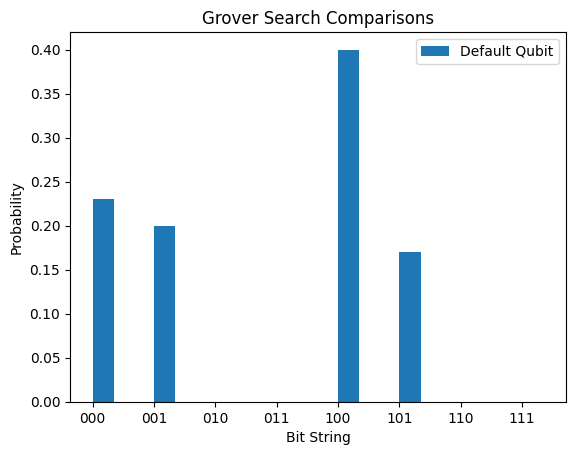

In [96]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from functools import partial
# Defining the oracle and the GroverSearch function
n_wires = 3
wires = list(range(n_wires))

def oracle():
    qml.Hadamard(wires[-1])
    qml.Toffoli(wires=wires)
    qml.Hadamard(wires[-1])

def GroverSearch(device, num_iterations=1):
    dev = device
    
    n_qubit = 3
    
    @partial(qml.cut_circuit_mc, auto_cutter=True)
    @qml.qnode(dev)
    def circuit():
        x = 0.531
        qml.Hadamard(wires=0)
        qml.Hadamard(wires=1)


        qml.CZ(wires=[0, 1])
        qml.Hadamard(wires=0)

        qml.CZ(wires=[1, 2])

        return qml.sample(wires=[0, 1, 2])
    

    res = circuit()
    print(res)
    bitstrings = ["{0:0{1}b}".format(i, n_qubit) for i in range(2**n_qubit)]
    probs = []
    str_res = []
    for r in res:
        str_res.append("".join([str(int(i)) for i in r]))
    for b in bitstrings:
        probs.append(str_res.count(b) / len(res))

    print(probs)

    return probs

# Devices
#alice_bob_dev = qml.device("alicebob.qubit", alice_backend="EMU:40Q:LOGICAL_TARGET", wires=3, average_nb_photons=8, kappa_1=10, kappa_2=1e8, shots=100)
default_dev = qml.device("default.qubit", wires=3, shots=100)

# Getting results from both devices
#alicebob_results = GroverSearch(alice_bob_dev, num_iterations=2)
default_results = GroverSearch(default_dev, num_iterations=2)

# Generating bit strings for x-axis labels
bit_strings = [f"{x:0{n_wires}b}" for x in range(2**n_wires)]

# Plotting
fig, ax = plt.subplots()
bar_width = 0.35
index = np.arange(len(default_results))

#bar1 = ax.bar(index, alicebob_results, bar_width, label='AliceBob Simulator')
bar2 = ax.bar(index + bar_width, default_results, bar_width, label='Default Qubit')

ax.set_xlabel('Bit String')
ax.set_ylabel('Probability')
ax.set_title('Grover Search Comparisons')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(bit_strings)
ax.legend()

plt.show()